## Spatial Query of CRESIS MCORDS

Just some notes on making a query in postGIS using a bounding box in one projection where the geometry column for the data is in another projection.  Start by finding the Polar Stereo coordinates of a point in Jakobshavn Fjord.  The query the CRESIS data from the cresis_grn table for a box around that point.

To make it even easier I'm just starting with a box in PS coords.

In [2]:
# just use some python to create a bounding box string
jak_bbox=(-212483.24,-2334797.72,-57857.51,-2209489.29)

psx_ll, psy_ll, psx_ur, psy_ur = jak_bbox

coords = "{0} {1},".format(psx_ll, psy_ll) + \
    "{0} {1},".format(psx_ll, psy_ur) + \
    "{0} {1},".format(psx_ur, psy_ur) + \
    "{0} {1},".format(psx_ur, psy_ll) + \
    "{0} {1}".format(psx_ll, psy_ll)
    
bbox = "ST_MakePolygon(ST_GeomFromText('LINESTRING({0})',3413))".format(coords)
print bbox

ST_MakePolygon(ST_GeomFromText('LINESTRING(-212483.24 -2334797.72,-212483.24 -2209489.29,-57857.51 -2209489.29,-57857.51 -2334797.72,-212483.24 -2334797.72)',3413))


Given this polygon the SQL query to extract the point would be something like the following:

    select count(*) from cresis_grn where
    ST_Contains(ST_MakePolygon(ST_GeomFromText(
    'LINESTRING(-212483.24 -2334797.72,-212483.24 -2209489.29,-57857.51 
    -2209489.29,-57857.51 -2334797.72,-212483.24 -2334797.72)',3413)),
    ST_Transform(the_geom,3413));
    
Note this is a rather large box around a rather well sampled region.  The above query returned, 3087753 rows (when this notebooks was created.)  Find the middle point then create a smaller box (1km x 1km ?) and retry query.

In [4]:
cntr_x = jak_bbox[0] + (jak_bbox[2] - jak_bbox[0])/2.
cntr_y = jak_bbox[1] + (jak_bbox[3] - jak_bbox[1])/2.
print cntr_x, cntr_y

grid_xsize = 1000
grid_ysize = 1000
grid_dx = grid_xsize / 2.
grid_dy = grid_ysize / 2.
jak_bbox = [cntr_x - grid_dx, cntr_y - grid_dy, cntr_x + grid_dx, cntr_y + grid_dy]

psx_ll, psy_ll, psx_ur, psy_ur = jak_bbox

coords = "{0} {1},".format(psx_ll, psy_ll) + \
    "{0} {1},".format(psx_ll, psy_ur) + \
    "{0} {1},".format(psx_ur, psy_ur) + \
    "{0} {1},".format(psx_ur, psy_ll) + \
    "{0} {1}".format(psx_ll, psy_ll)
    
bbox = "ST_MakePolygon(ST_GeomFromText('LINESTRING({0})',3413))".format(coords)
print bbox
query = "select count(*) from cresis_grn where ST_Contains({0},ST_Transform(the_geom,3413));"
query = query.format(bbox)
print query

-135170.375 -2272143.505
ST_MakePolygon(ST_GeomFromText('LINESTRING(-135670.375 -2272643.505,-135670.375 -2271643.505,-134670.375 -2271643.505,-134670.375 -2272643.505,-135670.375 -2272643.505)',3413))
select count(*) from cresis_grn where ST_Contains(ST_MakePolygon(ST_GeomFromText('LINESTRING(-135670.375 -2272643.505,-135670.375 -2271643.505,-134670.375 -2271643.505,-134670.375 -2272643.505,-135670.375 -2272643.505)',3413)),ST_Transform(the_geom,3413));


This query resulted in 2729 rows returned.  That's a more manageable number but we could probably go even smaller.  For this "gridcell" we get 17 unique dates:

     icedb=> select distinct(fltdate) from cresis_grn where
     ST_Contains(ST_MakePolygon(ST_GeomFromText('LINESTRING(-135670.375 -2272643.505,
     -135670.375 -2271643.505,-134670.375 -2271643.505,-134670.375 -2272643.505,
     -135670.375 -2272643.505)',3413)), ST_Transform(the_geom,3413));

      fltdate   
    ------------
     2005-05-14
     2010-05-14
     2006-05-26
     2005-05-17
     2009-03-31
     2014-04-19
     2011-04-08
     2009-04-02
     2009-04-04
     2014-04-09
     2005-05-22
     2006-05-29
     2012-04-21
     2013-04-04
     2013-04-10
     2003-05-11
     2006-05-27
    (17 rows)   

Our goal is to difference the surface elevation from each of these 2729 shots with the GIMP DEM elevation at that location AND come up with a measure of the difference between the surface at each date and GIMP.  That could be as simple as the mean and standard deviation of all the difference.  Or a weighted mean and standard deviation where the weight is the normalized inverse distance from the cell center.

Set up a database query to retrieve the data

In [15]:
import psycopg2
import numpy as np

DBNAME = 'icedb'
DBHOST = 'icebridge.sr.unh.edu'
DBUSER = 'nobody'
DBPORT = '5432'
EPSG_CODE = 3413

# make database connection
conn_str = 'host={0} dbname={1} user={2}'.format(DBHOST, DBNAME, DBUSER)
try:
    conn = psycopg2.connect(conn_str)
except:
    print "connection to database failed"

In [10]:
# set up cursor for query
mycur = conn.cursor()
query = "select count(*) from cresis_grn where ST_Contains({0}," + \
        "ST_Transform(the_geom,3413));"
query = query.format(bbox)

mycur.execute(query)
results = mycur.fetchall()
print results
mycur.close()

[(2729L,)]


Okay, I've added a `wgs84surf` column using the GIMP 30m DEM to the table.  So try to query the elevation, surface, and wgs84surf values from for the small box.

In [11]:
mycur = conn.cursor()
query = "select lat, lon, fltdate, elevation, surface, wgs84surf from cresis_grn " + \
    "where ST_Contains({0},ST_Transform(the_geom,3413));"
query = query.format(bbox)
print query
mycur.execute(query)
results = mycur.fetchall()
mycur.close()
print results[0]

select lat, lon, fltdate, elevation, surface, wgs84surf from cresis_grn where ST_Contains(ST_MakePolygon(ST_GeomFromText('LINESTRING(-135670.375 -2272643.505,-135670.375 -2271643.505,-134670.375 -2271643.505,-134670.375 -2272643.505,-135670.375 -2272643.505)',3413)),ST_Transform(the_geom,3413));
(69.211373, -48.395392, datetime.date(2005, 5, 14), 1578.59, -16.52, 1257)


This query takes about 45 seconds.  Which is pretty long.  Using the postgresql `EXPLAIN` command it is pretty clear that the query plan is just doing a sequential scan of all the rows in the table.  Right now there are 30+ million rows!  To speed up the query we can try to make use of the GIST index on the table.  

In [16]:
# used proj to calculat lat-lon of center point
cntr_lon = -48.40453
cntr_lat = 69.21005 

mycur = conn.cursor()
query_0 = "select lat, lon, fltdate, elevation, surface, wgs84surf from cresis_grn "
query_1 = "where ST_DWithin(ST_GeometryFromText('POINT({0} {1})',4326), the_geom, .25) "
query_1 = query_1.format(cntr_lon,cntr_lat)
query_2 = "and ST_Contains({0},ST_Transform(the_geom,3413)) order by fltdate;".format(bbox)
query = query_0 + query_1 + query_2
print query
mycur.execute(query)
results = mycur.fetchall()
mycur.close()
print results[0]

select lat, lon, fltdate, elevation, surface, wgs84surf from cresis_grn where ST_DWithin(ST_GeometryFromText('POINT(-48.40453 69.21005)',4326), the_geom, .25) and ST_Contains(ST_MakePolygon(ST_GeomFromText('LINESTRING(-135670.375 -2272643.505,-135670.375 -2271643.505,-134670.375 -2271643.505,-134670.375 -2272643.505,-135670.375 -2272643.505)',3413)),ST_Transform(the_geom,3413)) order by fltdate;
(69.210854, -48.415228, datetime.date(2003, 5, 11), 1931.0, 7.55, 1252)


This query executed in about 1.5 seconds!  Almost 30 times faster.  Probably if we converted the geometry to EPSG:3413 it would go even faster.  Then we'd have everything in the same coordinate system and no projections would be required.

In [17]:
import pandas as pd
data = pd.DataFrame(results,
                    columns=['lat','lon','fltdate','elevation','surface','wgs84surf'])
data['fltdate'] = pd.to_datetime(data['fltdate'])
print data.dtypes
data.head()

lat                 float64
lon                 float64
fltdate      datetime64[ns]
elevation           float64
surface             float64
wgs84surf             int64
dtype: object


,lat,lon,fltdate,elevation,surface,wgs84surf
0,69.210854,-48.415228,2003-05-11,1931.00,7.55,1252
1,69.212749,-48.393223,2003-05-11,1604.60,-120.17,1256
2,69.212746,-48.393299,2003-05-11,1604.49,-120.17,1256
3,69.212744,-48.393376,2003-05-11,1604.38,-120.17,1256
4,69.212741,-48.393452,2003-05-11,1604.27,-120.17,1256


In [23]:
data['delta'] = data['elevation'] - data['wgs84surf']
data.head()

,lat,lon,fltdate,elevation,surface,wgs84surf,delta
0,69.210854,-48.415228,2003-05-11,1931.00,7.55,1252,679.00
1,69.212749,-48.393223,2003-05-11,1604.60,-120.17,1256,348.60
2,69.212746,-48.393299,2003-05-11,1604.49,-120.17,1256,348.49
3,69.212744,-48.393376,2003-05-11,1604.38,-120.17,1256,348.38
4,69.212741,-48.393452,2003-05-11,1604.27,-120.17,1256,348.27


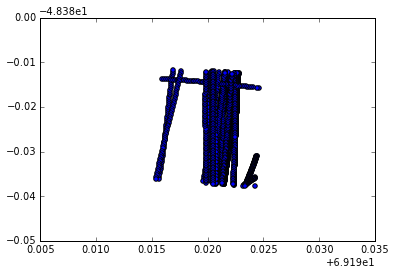

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(data['lat'], data['lon'])

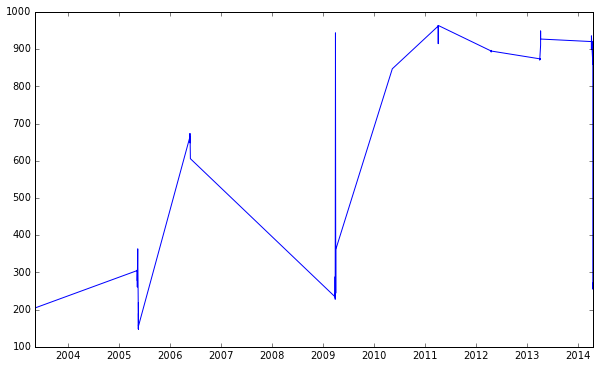

In [22]:
plt.figure(figsize=[10,6])
plt.plot(data['fltdate'], data['delta'])